In [1]:
# User based collaborative filtering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.model_selection import KFold

In [2]:
# Read the data
data = pd.read_csv('ratings_small.csv')

In [3]:
# Mean squared difference function
def msd(x, y):
    return np.mean((x - y)**2)

# Cosine similarity function
def cosine(x, y):
    denoavgator = np.linalg.norm(x) * np.linalg.norm(y)
    if denoavgator == 0:
        return 0
    return np.dot(x, y) / denoavgator

# Pearson correlation function
def pearson_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x = x - x_mean
    y = y - y_mean
    denominator = np.linalg.norm(x) * np.linalg.norm(y)
    if denominator == 0:
        return 0
    return np.dot(x, y) / denominator

In [4]:
# Compute the similarity matrix
def compute_similarity_matrix(data, similarity_function):
    # Create a matrix with the same size as the data
    similarity_matrix = np.zeros((data.shape[0], data.shape[0]))

    # similarity store
    similarity_store = {}

    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            if (i,j) in similarity_store:
                similarity_matrix[i, j] = similarity_store[(i,j)]
            elif (j,i) in similarity_store:
                similarity_matrix[i, j] = similarity_store[(j,i)]
            else:
                # Compute the similarity
                similarity_matrix[i, j] = similarity_function(data[i, :], data[j, :])
                similarity_store[(i,j)] = similarity_matrix[i, j]
            
    return similarity_matrix

In [5]:
def user_collaborative_filtering(neighbours, user_similarities, test_dataset, user_item_data):
    predictions = []
    actual = []
    for row in test_dataset.iterrows():
        # Get the user id and movie id
        user_id = int(row[1]['userId'])
        movie_id = int(row[1]['movieId'])

        # Get the user index
        user_index = user_item_data.index.get_loc(user_id)

        # Get the movie index

        try:
            movie_index = user_item_data.columns.get_loc(movie_id)
        except:
            predictions.append(0)
            actual.append(row[1]['rating'])
            continue

        # Get the user similarity
        user_similarity = user_similarities[user_index, :]

        # Get the known ratings
        known_ratings = user_item_data.values[:, movie_index]

        # Get the top k neighbours
        top_k_neighbours = np.argsort(user_similarity)[-(neighbours+1):]

        # exclude the user itself
        top_k_neighbours = top_k_neighbours[top_k_neighbours != user_index]

        # Get the top k similarity
        top_k_similarity = user_similarity[top_k_neighbours]

        # Get the top k ratings
        top_k_ratings = known_ratings[top_k_neighbours]

        # Get the predicted rating
        prediction = np.sum(top_k_similarity * top_k_ratings) / np.sum(np.abs(top_k_similarity))

        # Append the prediction and actual
        predictions.append(prediction)
        actual.append(row[1]['rating'])
    
    return actual, predictions

In [6]:
# RMSE
def rmse(actual, predictions):
    return sqrt(mean_squared_error(actual, predictions))

# MAE
def mae(actual, predictions):
    return mean_absolute_error(actual, predictions)

In [7]:
data_splits = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# Create a pivot table
user_item_data = data.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

# Calculate the cosine similarity
cosine_similarity = compute_similarity_matrix(user_item_data.values, cosine)

# Calculate the pearson correlation
pearson_similarity = compute_similarity_matrix(user_item_data.values, pearson_correlation)

# Calculate the msd
msd_similarity = compute_similarity_matrix(user_item_data.values, msd)

In [31]:
# 5 fold cross validation for cosine similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(10, cosine_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [00:27,  5.49s/it]



RMSE:  [2.5267686687709094, 2.523765526976661, 2.5167384675207014, 2.5203401557986163, 2.508831915113397]
Average RMSE:  2.519288946836057
MAE:  [2.1976509162271785, 2.1952210984115075, 2.185726424483016, 2.1872853324892496, 2.1758581012226843]
Average MAE:  2.188348374566727


In [32]:
# 5 fold cross validation for pearson similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(10, pearson_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [00:26,  5.20s/it]



RMSE:  [2.5847748600045484, 2.5830718028025674, 2.5760593263381217, 2.5798081177574166, 2.5667171397410637]
Average RMSE:  2.5780862493287438
MAE:  [2.262028102710649, 2.2613689581200704, 2.251434685753507, 2.2540108817516527, 2.242085346526734]
Average MAE:  2.2541855949725225


In [33]:
# 5 fold cross validation for msd similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(10, msd_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [00:20,  4.09s/it]



RMSE:  [2.4291783412325345, 2.423742496819524, 2.416926937875688, 2.4168295886299456, 2.4171535459212783]
Average RMSE:  2.420766182095794
MAE:  [2.1081787183732232, 2.106222360436661, 2.0926271484268852, 2.094573457083122, 2.093084932257455]
Average MAE:  2.098937323315469


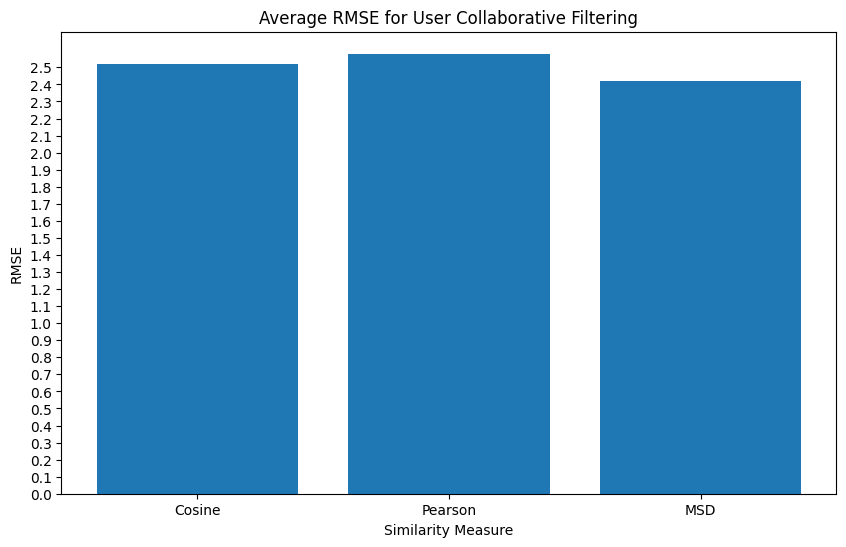

In [40]:
cosine_avg_rmse = 2.52
pearson_avg_rmse = 2.58
msd_avg_rmse = 2.42

plt.bar(['Cosine', 'Pearson', 'MSD'], [cosine_avg_rmse, pearson_avg_rmse, msd_avg_rmse])
plt.title('Average RMSE for User Collaborative Filtering')
plt.xlabel('Similarity Measure')
plt.ylabel('RMSE')
plt.yticks(np.arange(0, 2.6, step=0.1))
plt.show()


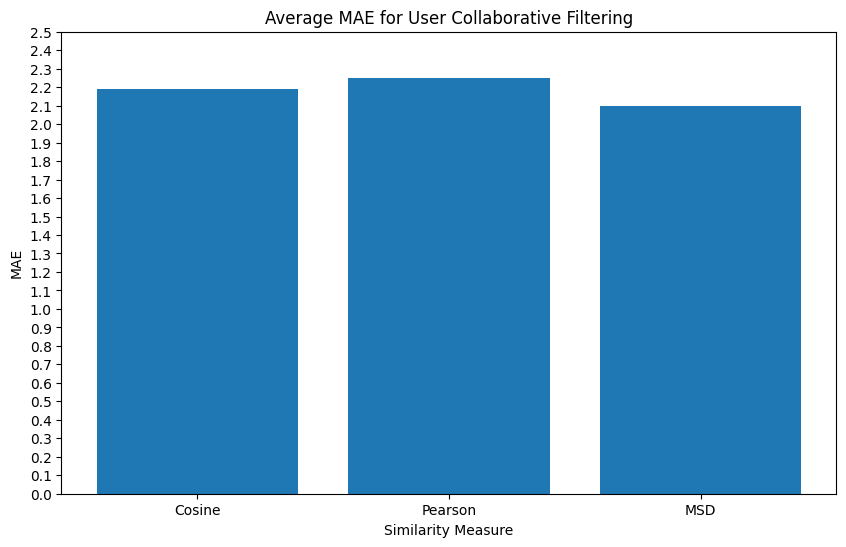

In [41]:
cosine_avg_mae = 2.19
pearson_avg_mae = 2.25
msd_avg_mae = 2.10

plt.bar(['Cosine', 'Pearson', 'MSD'], [cosine_avg_mae, pearson_avg_mae, msd_avg_mae])
plt.title('Average MAE for User Collaborative Filtering')
plt.xlabel('Similarity Measure')
plt.ylabel('MAE')
plt.yticks(np.arange(0, 2.6, step=0.1))
plt.show()

In [9]:
# Split the data into train and test
_, test = train_test_split(data, test_size=0.2, random_state=42)

100%|██████████| 18/18 [01:13<00:00,  4.08s/it]


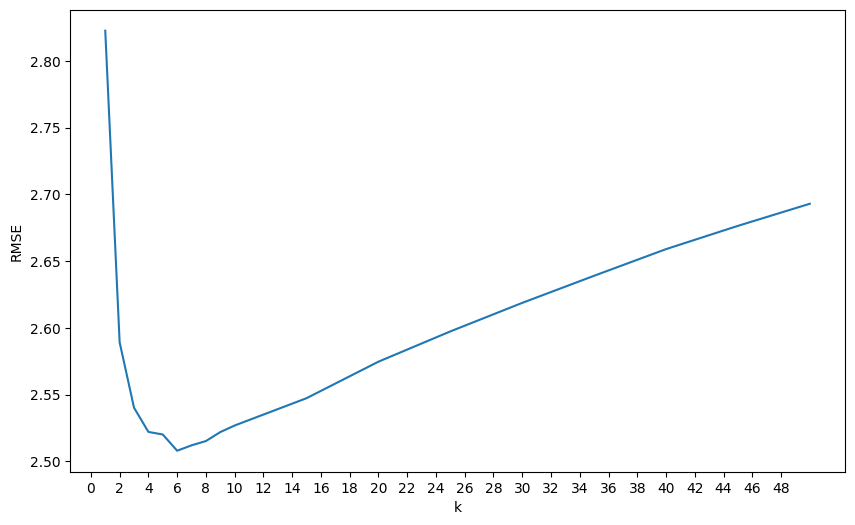

In [23]:
# find the best k and plot rmse against k for cosine similarity
k_values = [1,2,3,4,5,6,7,8,9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_values = []

for k in tqdm(k_values):

    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(k, cosine_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_values.append(rmse(actual, predictions))

# Plot the rmse against k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(np.arange(0, 50, step=2))
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|██████████| 18/18 [01:14<00:00,  4.12s/it]


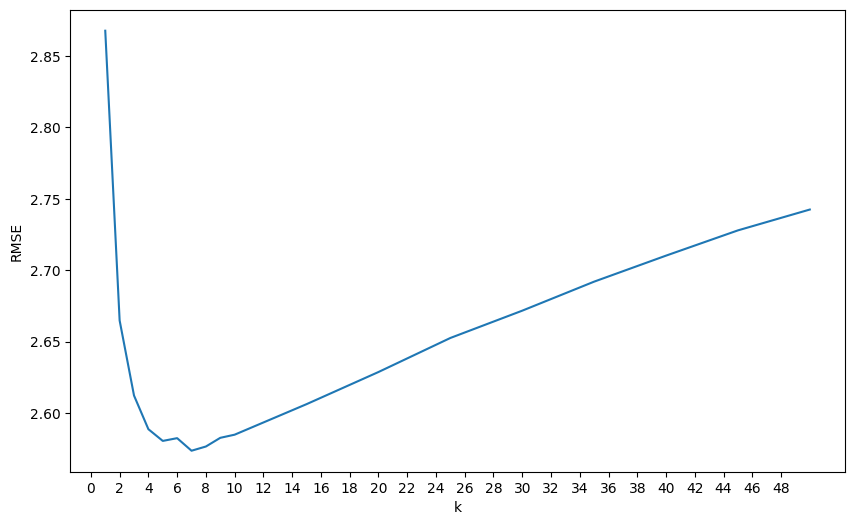

In [24]:
# find the best k and plot rmse against k for pearson correlation
k_values = [1,2,3,4,5,6,7,8,9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_values = []

for k in tqdm(k_values):

    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(k, pearson_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_values.append(rmse(actual, predictions))

# Plot the rmse against k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(np.arange(0, 50, step=2))
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

100%|██████████| 18/18 [01:02<00:00,  3.49s/it]


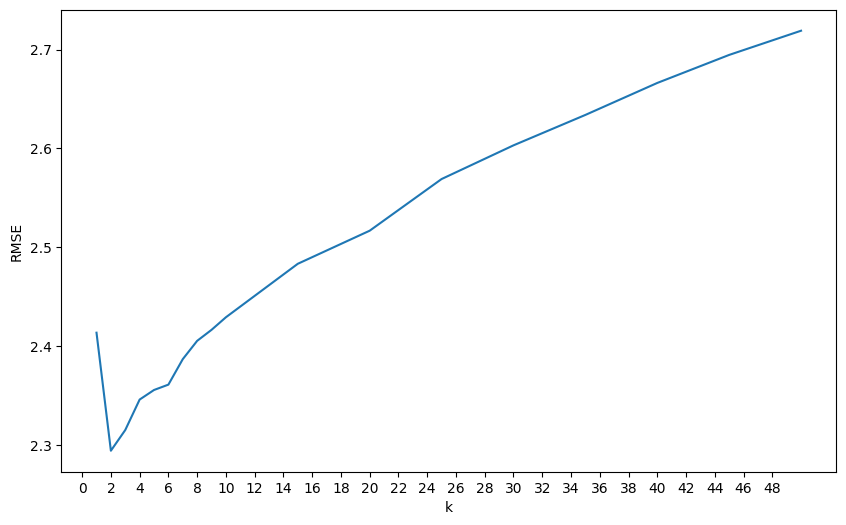

In [25]:
# find the best k and plot rmse against k for msd
k_values = [1,2,3,4,5,6,7,8,9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_values = []

for k in tqdm(k_values):

    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(k, msd_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_values.append(rmse(actual, predictions))

# Plot the rmse against k
plt.plot(k_values, rmse_values)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.xticks(np.arange(0, 50, step=2))
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [26]:
# 5 fold cross validation for cosine similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(6, cosine_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [00:20,  4.05s/it]



RMSE:  [2.507870145078314, 2.5000687376432085, 2.495587702827188, 2.4995694147160545, 2.4863858648009702]
Average RMSE:  2.4978963730131474
MAE:  [2.153409613013743, 2.1461053102179006, 2.138913455026778, 2.1421770132838063, 2.12863152494278]
Average MAE:  2.1418473832970015


In [27]:
# 5 fold cross validation for pearson similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(7, pearson_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [00:24,  4.98s/it]



RMSE:  [2.5735373482925596, 2.570273788805865, 2.5646465389481845, 2.5710656485829384, 2.553787915911246]
Average RMSE:  2.566662248108159
MAE:  [2.235267161208955, 2.2328046583237007, 2.2253440351688094, 2.231059721665157, 2.2149660715142288]
Average MAE:  2.22788832957617


In [28]:
# 5 fold cross validation for msd similarity
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    # Get the actual and predictions
    actual, predictions = user_collaborative_filtering(2, msd_similarity, test, user_item_data)

    # Calculate the rmse
    rmse_results.append(rmse(actual, predictions))

    # Calculate the mae
    mae_results.append(mae(actual, predictions))

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

5it [00:19,  3.89s/it]



RMSE:  [2.294176866117479, 2.2911122286384757, 2.278103897368488, 2.2864111320130047, 2.286721164690965]
Average RMSE:  2.2873050577656824
MAE:  [1.9262840607647096, 1.9240975156905928, 1.9087426023242502, 1.916944969504993, 1.9146574342197404]
Average MAE:  1.9181453165008573
